<center><h1>Introduction to image processing - Color transfer with Sinkhorn</h1>

# Introduction
For the following exercices, you need Python 3 with some basic librairies (see below).
All images necessary for the session are available [here](https://github.com/judelo/notebooks/tree/master/im). 

If you use your own Python 3 install, you should download the images, put them in a convenient directory and update the path in the next cell.

For some parts of the session (cells with commands written as `todo_something`...), you are supposed to code by yourself.   

In [1]:
path = '../im/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as sd

from sklearn.cluster import KMeans

from time import time

The following line will be used to import the solutions of the practical session. Do not use it for the moment.

In [3]:
from TP_color_transfer import *

**Load and display a color image**. A color image is made of three channels : red, green and blue. A color image in $\mathbb{R}^{N\times M}$ is stored as a $N\times M\times 3$ matrix.


<span style="color:red">
    
**Be careful with the functions `plt.imread()` and `plt.imshow()` of `matplotlib`.** 
- `plt.imread()` reads png images as numpy arrays of floating points between 0 and 1, but it reads jpg or bmp images as numpy arrays of 8 bit integers. 

- **In this practical session, we assume floating point images between 0 and 1, so if you use jpg or bmp images, you should normalize them to $[0,1]$.** 

- If 'im' is an image encoded as a double numpy array, `plt.imshow(im)` will display all values above 1 in white and all values below 0 in black. If the image 'im' is encoded on 8 bits though, `plt.imshow(im)` will display 0 in black and 255 in white.</span>

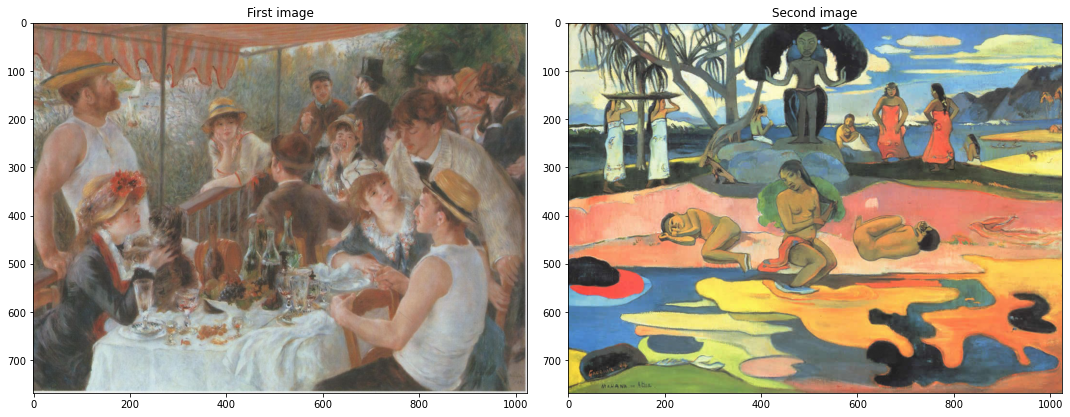

In [4]:
imrgb1 = plt.imread(path+'renoir.jpg')/255
imrgb2 = plt.imread(path+'gauguin.jpg')/255
imrgb1=imrgb1[:,:,0:3] # useful if the image is a png with a transparency channel
imrgb2=imrgb2[:,:,0:3] 

#we display the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].imshow(imrgb1)
axes[0].set_title('First image')
axes[1].imshow(imrgb2)
axes[1].set_title('Second image')
fig.tight_layout()

## Reminders on Entropic optimal transport 


The entropy of a matrix $\gamma$ (with positive entries) is defined as: $$H(\gamma) = \sum_{i,j} \gamma_{i,j}(\log(\gamma_{i,j})-1)$$

Let $\mu_0 = \sum_{i=1}^{K_0} s_i \;\delta_{x_i}$ and $\mu_1 = \sum_{j=1}^{K_1} t_j\,\delta_{y_j}$ be two discrete measures with $\sum_i s_i = \sum_j t_j=1$. Define 
$$\Pi(\mu_0,\mu_1) = \{\gamma, \; \gamma_{i,j} \ge 0, \sum_i \gamma_{i,j} = t_j, \sum_j \gamma_{i,j} =s_i
\}.$$

The entropic Optimal Transport proposed by Cuturi in 2013 is the following optimization problem :

$$ \underset{\gamma \in \Pi(\mu_0,\mu_1)}{\mathrm{argmin}} \sum_{i,j} c(x_i,y_j)\gamma_{i,j} - {\color{blue} \varepsilon H(\gamma)} $$

$\text{With }K_{i,j} = e^{-\frac 1 \varepsilon c(x_i,y_j)} \text{ the problem becomes}$

$$ \underset{\gamma \in \Pi(\mu_0,\mu_1)}{\mathrm{argmin}} \sum_{i,j} \gamma_{i,j} \log \left(\frac{\gamma_{i,j}}{K_{i,j}}\right) = \underset{\gamma \in \Pi(\mu_0,\mu_1)}{\mathrm{argmin}} \mathrm{KL}(\gamma||K) $$

### Sinkhorn algorithm

The solution can be obtained by projecting alternatively on the constraints of $\Pi(\mu_0,\mu_1)$, starting from $\gamma_0 =  K$.

It can be shown that the solution $\gamma$ of $\underset{\gamma \in \Pi(\mu_0,\mu_1)}{\mathrm{argmin}} \mathrm{KL}(\gamma||K)$ can be written $\gamma = \mathrm{diag}(a) K \,\mathrm{diag}(b)$.

Since $\gamma \in \Pi(\mu_0,\mu_1)$ it implies that $a \odot Kb = \mu_0$ and $b \odot K^Ta = \mu_1$. In other words, the iterations can be written directly on $a$ and $b$, which can be initialized to (normalized) constant vectors and updated as follows

$$a_{k+1} \leftarrow \frac {\mu_0} {Kb_k} \;\;\;  b_{k+1} \leftarrow \frac {\mu_1} {K^Ta_k}.$$ 


## Sinkhorn with matrix vector multiplications

The previous algorithm requires matrix vector multiplications. Matrix $K$ can be huge for imaging applications. Typically for color transfer, in a naive version of the Sinkhorn algorithm considering Lagrangian color histograms (point clouds) for two images with respectively $n$ and $m$  pixels, $K$ would be a $n times m$ matrix!
In what follows we apply this naive Sinkhorn by dividing each image by 16 in each dimension.

In [5]:
# subsampling of images by a factor s and creation of point clouds

u          = imrgb1
v          = imrgb2
s          = 16                          # choose s well depending on what you want to apply next
if s==1:
        usubsample = u
        vsubsample = v
else:
        usubsample = u[1::s,1::s,0:3]
        vsubsample = v[1::s,1::s,0:3]
X          = usubsample.reshape((usubsample.shape[0]*usubsample.shape[1],3))
Y          = vsubsample.reshape((vsubsample.shape[0]*vsubsample.shape[1],3))

In [6]:
n = X.shape[0]
a,b = np.ones((n,)) / n, np.ones((n,)) /n 
f,g = np.ones((n,)) / n, np.ones((n,)) /n 
start = time()

# matrix of distances between grids 
M = np.sum(X**2,axis=1).reshape(n,1)@np.ones((1,n)) + np.ones((n,1))@np.sum(Y**2,axis=1).T.reshape(1,n) - 2*X@Y.T
#M /= M.max()

niter = 100
eps = 0.01
A = np.exp(-M/eps)

# Sinkhorn 
for t in range(niter):  
    a = f / (A@b)
    b = g / (A.T@a)

G0 = np.diag(a)@A@np.diag(b)
Z = Y[np.argmax(G0,axis=1)]
print("elapsed =", time() - start)

elapsed = 1.7611970901489258


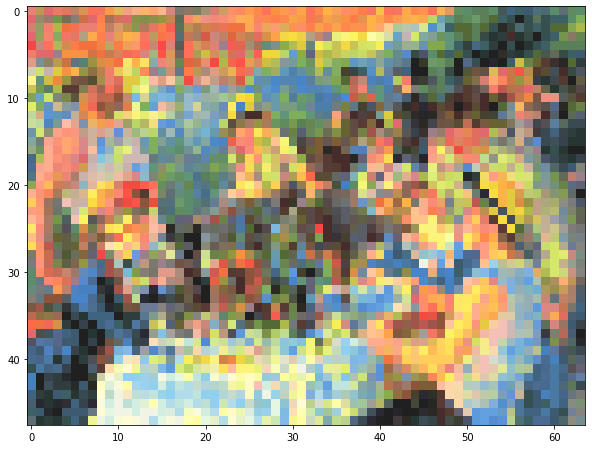

In [7]:
Zim = Z.reshape(usubsample.shape)
plt.figure(figsize=(10,10))
plt.imshow(Zim)
plt.show()

## Sinkhorn with convolutions on a regular grid (but not 256 x 256 x 256) 
The previous algorithm cannot be used with full size versions because matrix $K$ is too large. 

Instead, we can implement a smarter version of Sinkhorn using the fact that image colors usually belong to a regular  $N\times N\times N$ grid (with $N=256$ for 8bit images). Considering Eulerian color histograms on this $N\times N\times N$ grid, the distance matrix $M$ becomes a very regular $N^3 \times N^3$ matrix since the distance between two colors of the grid depends only of the relative positions of the two colors on the grid. 

Hence, between two colors of respective coordinates $(i,j,k)$ and $(l,m,n)$, the kernel $K$ is such that
$$K(i,j,k,l,m,n) = \exp(-((i-l)^2+(j-m)^2+(k-n)^2)/(\epsilon N^2)).$$
In practice, $K$ will never be stored but multiplications with $K$ can be computed easily.

Indeed, the multiplication $Ka$ can also be written  
$$Ka(i,j,k) = \sum_{l,m,n}\exp(-((i-l)^2+(j-m)^2+(k-n)^2)/(\epsilon N^2)) \times a(l,m,n) $$
and this product can be implemented as a succession of 3 one dimensional convolutions of the histogram a in each  dimension with a simple Gaussian kernel.

In what follows, we implement this second version for a 64 x 64 x 64 grid (it should take a few seconds). The same algorithm should work also with a 128x128x128 if you are patient (it takes 1min40 on a standard computer dating from 2015). 


In [8]:
# 3D sinkhorn with convolutions
t1 = time()
niter = 20
N = 64        # histogram on a N x N x N uniform grid  
eps = 0.01    # regularisation parameter for Sinkhorn

# probability vectors
u          = np.floor(np.double(imrgb1*(N-0.01)))     # first image with N values for each channel 
v          = np.floor(np.double(imrgb2*(N-0.01)))     # second image with N values for each channel

# we compute histograms for both images
f, g = np.zeros((N,N,N)), np.zeros((N,N,N))          # initialization 
for k in range(u.shape[0]):
    for j in range(u.shape[1]):
        f[int(u[k,j,:][0]),int(u[k,j,:][1]),int(u[k,j,:][2])]+=1
for k in range(v.shape[0]):
    for j in range(v.shape[1]):
        g[int(v[k,j,:][0]),int(v[k,j,:][1]),int(v[k,j,:][2])]+=1
                
f, g = f/np.sum(f), g/np.sum(g)       


# initialization of vectors a and b for Sinkhorn 
a, b = np.ones((N,N,N)), np.ones((N,N,N))
a, b = a/np.sum(a), b/np.sum(b)       


# distance matrix and corresponding filter for convolutions (= replaces matrix vectors products)
h=np.zeros((2*N-1,))
x = np.linspace(0,N-1,N)
w = np.exp(-x**2/(N**2*eps)) 
h[N-1:2*N-1]=np.copy(w)
h[0:N-1]= w[N:0:-1]

# Sinkhorn 
for t in range(niter):
    Ab = sd.convolve(b,h.reshape(1,1,2*N-1),mode='constant')   
    Ab = sd.convolve(Ab,h.reshape(1,2*N-1,1),mode='constant') 
    Ab = sd.convolve(Ab,h.reshape(2*N-1,1,1),mode='constant')  
    a = f / Ab
    Aa = sd.convolve(a,h.reshape(1,1,2*N-1),mode='constant')
    Aa = sd.convolve(Aa,h.reshape(1,2*N-1,1),mode='constant')  
    Aa = sd.convolve(Aa,h.reshape(2*N-1,1,1),mode='constant') 
    b = g / Aa

t2 = time()
print(t2-t1) 
print('sinkhorn done')


6.388097763061523
sinkhorn done


Once we have computed the Sinkhorn solution for our  $N \times N \times N$ grid (the solution is given by the final values of a and b), we should find a way to deduce an assignement for each color of the grid without computing the multiplication $\mathrm{diag}(a) K \,\mathrm{diag}(b)$.
Observe that $\mathrm{diag}(a) K \,\mathrm{diag}(b)$ is a $N^3 \times N^3$ matrix such that 

$$\mathrm{diag}(a) K \,\mathrm{diag}(b) \; (i,j,k,l,m,n) = a (i,j,k) K (i,j,k,l,m,n) b (l,m,n).$$

The previous matrix does not define a one-to-one color correspondence. To define a matching between colors, 
for a starting color $(i,j,k)$, we propose to compute the corresponding color as the position of the maximum of $\mathrm{diag}(a) K \,\mathrm{diag}(b)$ on its line $(i,j,k)$. It is equivalent to look for the position of the maximum of  $(l,m,n) \rightarrow K (i,j,k,l,m,n) b (l,m,n)$.

5.907819032669067


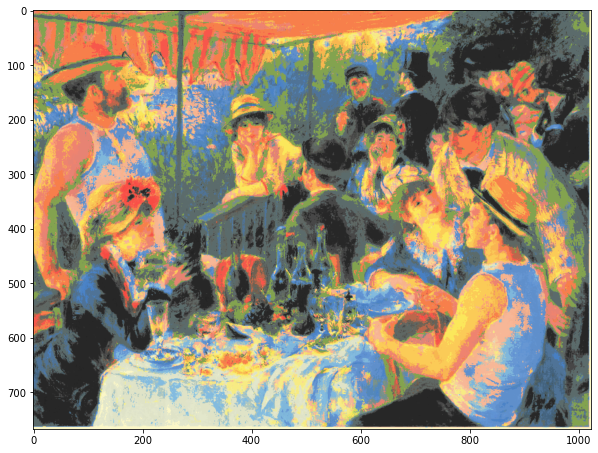

In [9]:
# do the computations only for g != 0

t1 = time()

otmap = np.zeros((N,N,N,3))

X = np.array(np.nonzero(f))
Y = np.array(np.nonzero(g))
bY = b[tuple(Y)]

for t in range(X.shape[1]):
    l,m,n = np.uint8(X[:,t])
    temp = np.exp(-((Y[0]-l)**2+(Y[1]-m)**2+(Y[2]-n)**2)/(N**2*eps))*bY
    ind = np.argmax(temp, axis=None)
    otmap[l,m,n,:] = Y[:,ind]
    
out = otmap[np.uint8(u[:,:,0]),np.uint8(u[:,:,1]),np.uint8(u[:,:,2]),:]/N

t2 = time()
print(t2-t1)

plt.figure(figsize = (10,10))
plt.imshow(out)

The color of the resulting image are quantized on a $N \times N \times N$ grid, which is not completely satisfying. We apply a simple postprocessing step in the following to improve the result visually.

# Postprocessing: Regularization 



A common drawback of classical methods aiming at color and contrast modifications is the revealing of artefacts (JPEG blocs, color inconsistancies, noise enhancement) or the attenuation of details and textures (see for instance the following [web page](http://perso.telecom-paristech.fr/~delon/artefact_removal_html/)). 
Let $u$ be an image and $g(u)$ the same  image after color or contrast modification, we write $\mathcal{M}(u) = g(u) - u$. All artefacts observable in $g(u)$ can be seen as irregularities in these difference map $\mathcal{M}(u)$. In order to reduce these artefacts, we propose to filter this difference map thanks to an operator $Y_u$ and to reconstruct the image:

$$T(g(u)) = u + Y_u(g(u)-u).$$


In [10]:
diff = out - imrgb1
out2 = np.zeros_like(imrgb1)

for i in range(3):
    out2[:,:,i] = todo_guided_filter(diff[:,:,i], imrgb1[:,:,i], 20,1e-4 )

We display the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


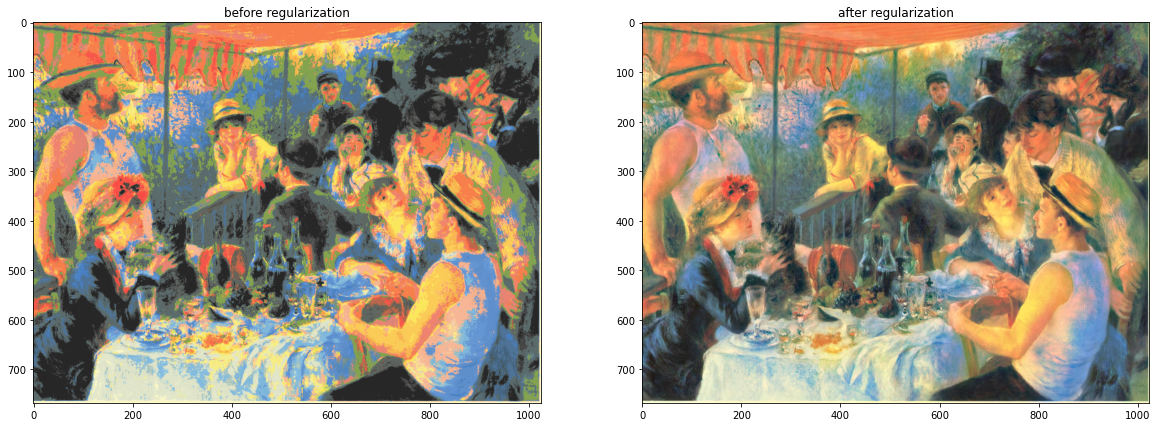

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(out)
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(out2+imrgb1)
plt.show()

Zoom on the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


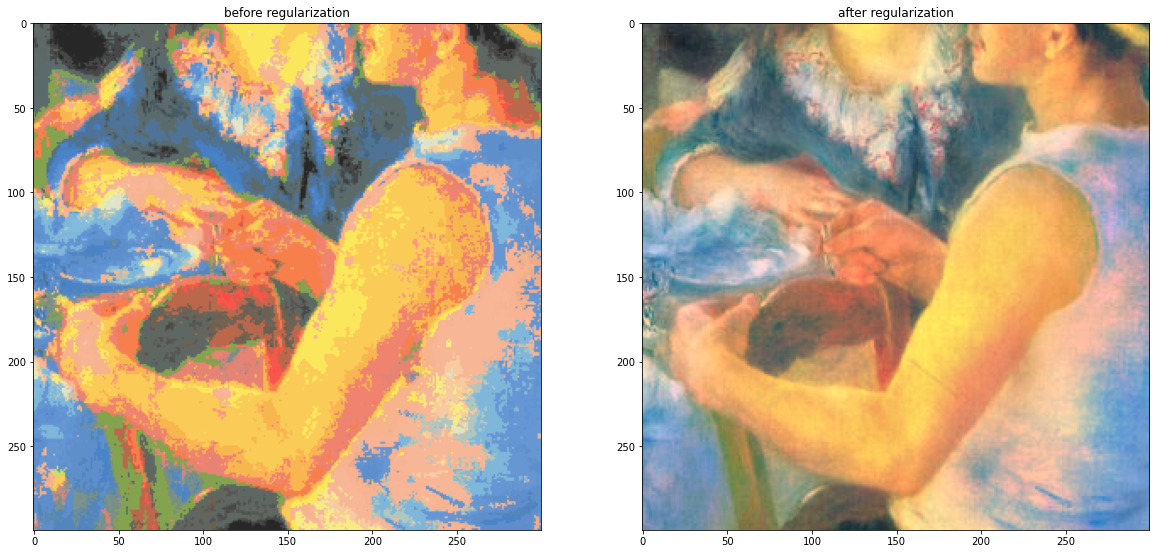

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(out[400:700,600:900,:])
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(imrgb1[400:700,600:900,:]+out2[400:700,600:900,:])
plt.show()